# EIOPA RISK-FREE CURVE DECEMBER-22 RECALCULATION
<a id="0"></a> <br>

The risk-free curve is one of the principal inputs into an economic scenario generator. This notebook recalculates the risk-free curve using the parameters that are claimed to be used. The European Insurance and Occupational Pensions Authority (EIOPA) publishes their own yield curve prediction. To do this they use the Smith & Wilson algorithm.

### Summary

The goal of this test is to replicate the EIOPA yield curve. This test will use the methodology that EIOPA claims it is using and the calibration vector that they publish. If the test is passed, the user can be more confident, that EIOPA risk free rate (RFR) curve was generated using the described methodology/calibration and that the process was implemented correctly. 


 # Table of Contents  
1. [Note on Smith & Wilson algorithm](#1)
2. [Data requirements](#2)
3. [Success criteria](#3)
4. [External dependencies](#4)
5. [Calibration parameters and calibration vector provided by EIOPA](#5)
6. [Smith & Wilson calculation functions](#6)
7. [Generation of the risk-free curve](#7)
8. [Test 1; Comparison test](#8)
9. [Test 1; Success criteria](#9)
10. [Test 1; Comparison test](#10)
11. [Conclusion](#11)

<a id="1"></a> <br>
## Note on Smith & Wilson algorithm

To replicate the calculations, this example uses a modified Smith&Wilson implementation (The original implementation is availible on [GitHub](https://github.com/qnity):
-  [Python](https://github.com/qnity/insurance_python/tree/main/smith%26wilson)
-  [Matlab](https://github.com/qnity/insurance_matlab/tree/main/smith%26wilson)
-  [JavaScript](https://github.com/qnity/insurance_javascript/tree/main/smith-wilson)

#### Limitations of the implementation
Current implementation only looks at a single currency and without any Volatility Adjustment (VA). The day count convention assumes that each year has the same number of days.

<a id="2"></a> <br>
## Data requirements

This script contains the EIOPA risk-free rate publication for December 2022. The publication can be found on the [EIOPA RFR website](https://www.eiopa.europa.eu/tools-and-data/risk-free-interest-rate-term-structures_en).

The observed maturities `M_Obs` and the calibrated vector `Qb` can be found in the Excel sheet *EIOPA_RFR_20221231_Qb_SW.xlsx*.

For this example, the curve without the volatility adjustment (VA) is used. It can be found in the sheet *SW_Qb_no_VA*. This example is focused on the EUR curve, but this example can be easily modified for any other curve.

The target maturities (`T_Obs`), the additional parameters (`UFR` and `alpha`), and the given curve can be found in the Excel *EIOPA_RFR_20221231_Term_Structures.xlsx*, sheet *RFR_spot_no_VA*.

[Back to the top](#0)
<a id="3"></a> <br>
## Success criteria

The following success criteria is defined:
-  Maximum difference between the calculated curve and the one provided by EIOPA is less than 0.1 bps
-  Average difference between the calculated curve and the one provided by EIOPA is less than 0.05 bps

In [349]:
test_statistics_max_diff_in_bps = 0.1
test_statistics_average_diff_in_bps = 0.05

The success function is called at the end of the test to confirm if the success criteria have been met.

In [350]:
def SuccessTest(TestStatistics, threshold_max, threshold_mean):
    out1 = False
    out2 = False
    if max(TestStatistics)<threshold_max:
        print("Test passed")
        out1 = True
    else:
        print("Test failed")

    if np.mean(TestStatistics)<threshold_mean:
        print("Test passed")
        out2 = True
    else:
        print("Test failed")
    return [out1, out2]

[Back to the top](#0)
<a id="4"></a> <br>
         
## External dependencies

This implementation uses three well established Python packages widely used in the financial industry. Pandas (https://pandas.pydata.org/docs/), Numpy (https://numpy.org/doc/), and Matplotlib (https://matplotlib.org/stable/index.html)

In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

## Importing data

In [352]:
selected_file = 'Param_no_VA.csv'
param_raw = pd.read_csv(selected_file, sep=',',index_col=0)

***
<span style=color:black>
    <b>Parameter input</b>
</span>
<br>
<span style=color:black>   
    Parameters sheet
</span>

In [353]:
param_raw.head()

,EUR_Maturities,EUR_Values,AT_Maturities,AT_Values,BE_Maturities,BE_Values,BG_Maturities,BG_Values,HR_Maturities,HR_Values,...,AU_Maturities,AU_Values,BR_Maturities,BR_Values,CA_Maturities,CA_Values,CL_Maturities,CL_Values,CN_Maturities,CN_Values
Country,,,,,,,,,,,,,,,,,,,,,
Coupon_freq,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,4.000000,4.000000
LLP,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,9.000000,9.000000,...,30.000000,30.000000,10.000000,10.000000,30.000000,30.000000,10.000000,10.000000,10.000000,10.000000
Convergence,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,51.000000,51.000000,...,40.000000,40.000000,50.000000,50.000000,40.000000,40.000000,50.000000,50.000000,50.000000,50.000000
UFR,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,3.450000,...,3.450000,3.450000,5.350000,5.350000,3.450000,3.450000,4.500000,4.500000,4.500000,4.500000
alpha,0.120275,0.120275,0.120275,0.120275,0.120275,0.120275,0.120849,0.120849,0.105408,0.105408,...,0.112886,0.112886,0.143158,0.143158,0.070266,0.070266,0.070948,0.070948,0.088062,0.088062


***

The country selected is:

In [354]:
country = "SI"

In [355]:
country+"_Maturities"

'SI_Maturities'

In [356]:
maturities_country_raw = param_raw.loc[:,country+"_Maturities"].iloc[6:]
param_country_raw = param_raw.loc[:,country+"_Values"].iloc[6:]
extra_param = param_raw.loc[:,country+"_Values"].iloc[:6]

***
<span style=color:black>
    <b>Extra parameters</b>
</span>
<br>
<span style=color:black>   
    Smith-Wilson calibration parameters
</span>

In [379]:
extra_param

Country
Coupon_freq     1.000000
LLP            20.000000
Convergence    40.000000
UFR             3.450000
alpha           0.120275
CRA            10.000000
Name: SI_Values, dtype: float64

***

In [357]:
relevant_positions = pd.notna(maturities_country_raw.values)

In [358]:
maturities_country = maturities_country_raw.iloc[relevant_positions]

***
<span style=color:black>
    <b>Maturity vector</b>
</span>
<br>
<span style=color:black>   
    Vector of maturities of calibration data
</span>

In [ ]:
maturities_country.head()

***

In [359]:
Qb = param_country_raw.iloc[relevant_positions]

***
<span style=color:black>
    <b>Calibration vector</b>
</span>
<br>
<span style=color:black>   
    Vector Qb provided as input
</span>

In [360]:
Qb

Country
1     10.410356
2    -12.456054
3      5.667547
4     -0.016150
5     -0.539124
6     -1.012348
7      1.345744
8      0.092938
9     -1.729729
10     5.078942
11    -6.952002
12     4.111449
13    -0.028440
14    -0.027492
15    -1.727604
16     0.024249
17     0.023440
18     0.022658
19     0.021903
20     0.770104
Name: SI_Values, dtype: float64

***

In [361]:
selected_file = 'Curves_no_VA.csv'
curve_raw = pd.read_csv(selected_file, sep=',',index_col=0)

In [362]:
curve_country = curve_raw.loc[:,country]

***
<span style=color:black>
    <b>Final yield curve</b>
</span>
<br>
<span style=color:black>   
    Full yield curve provided by EIOPA
</span>

In [363]:
curve_country.head(10)

Country
1     0.03176
2     0.03295
3     0.03203
4     0.03152
5     0.03131
6     0.03110
7     0.03091
8     0.03086
9     0.03088
10    0.03092
Name: SI, dtype: float64

***

[Back to the top](#0)
<a id="5"></a> <br>
## Calibration parameters and calibration vector provided by EIOPA

In [364]:
# Maturity of observations:
M_Obs = np.transpose(np.array(maturities_country.values))

# Ultimate froward rate ufr represents the rate to which the rate curve will converge as time increases:
ufr = extra_param.iloc[3]/100

# Convergence speed parameter alpha controls the speed at which the curve converges towards the ufr from the last liquid point:
alpha = extra_param.iloc[4]

# For which maturities do we want the SW algorithm to calculate the rates. In this case, for every year up to 150:
M_Target = np.transpose(np.arange(1,151)) 

# Qb calibration vector published by EIOPA for the curve calibration:
Qb = np.transpose(np.array(Qb.values))

[Back to the top](#0)
<a id="6"></a> <br>
## Smith & Wilson calculation functions

In this step, the independent version of the Smith&Wilson algorithm is implemented. To do this, two functions are taken from the publicly available repository and modified to accept the product of `Q*b` instead of the calibration vector `b`.

In [366]:
def SWExtrapolate(M_Target, M_Obs, Qb, ufr, alpha):
# SWEXTRAPOLATE Interpolate or/and extrapolate rates for targeted maturities using a Smith-Wilson algorithm.
# out = SWExtrapolate(M_Target, M_Obs, Qb, ufr, alpha) calculates the rates for maturities specified in M_Target using the calibration vector b.
#
# Arguments: 
#    M_Target = k x 1 ndarray. Each element represents a bond maturity of interest. Ex. M_Target = [[1], [2], [3], [5]]
#    M_Obs =    n x 1 ndarray. Observed bond maturities used for calibrating the calibration vector b. Ex. M_Obs = [[1], [3]]
#    Qb =       n x 1 ndarray. Calibration vector calculated on observed bonds.
#    ufr =      1 x 1 floating number. Representing the ultimate forward rate.
#       Ex. ufr = 0.042
#    alpha =    1 x 1 floating number. Representing the convergence speed parameter alpha. Ex. alpha = 0.05
# 
#
# Returns:
#    k x 1 ndarray. Represents the targeted rates for a zero-coupon bond. Each rate belongs to a targeted zero-coupon bond with a maturity from T_Target. Ex. r = [0.0024; 0.0029; 0.0034; 0.0039]
#
# For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf

    def SWHeart(u, v, alpha):
    # SWHEART Calculate the heart of the Wilson function.
    # H = SWHeart(u, v, alpha) calculates the matrix H (Heart of the Wilson
    # function) for maturities specified by vectors u and v. The formula is
    # taken from the EIOPA technical specifications paragraph 132.
    #
    # Arguments:  
    #    u =     n_1 x 1 vector of maturities. Ex. u = [1; 3]
    #    v =     n_2 x 1 vector of maturities. Ex. v = [1; 2; 3; 5]
    #    alpha = 1 x 1 floating number representing the convergence speed parameter alpha. Ex. alpha = 0.05
    #
    # Returns:
    #    n_1 x n_2 matrix representing the Heart of the Wilson function for selected maturities and parameter alpha. H is calculated as in the paragraph 132 of the EIOPA documentation. 
    #
    # For more information see https://www.eiopa.europa.eu/sites/default/files/risk_free_interest_rate/12092019-technical_documentation.pdf

        u_Mat = np.tile(u, [v.size, 1]).transpose()
        v_Mat = np.tile(v, [u.size, 1])
        return 0.5 * (alpha * (u_Mat + v_Mat) + np.exp(-alpha * (u_Mat + v_Mat)) - alpha * np.absolute(u_Mat-v_Mat) - np.exp(-alpha * np.absolute(u_Mat-v_Mat))); # Heart of the Wilson function from paragraph 132

    H = SWHeart(M_Target, M_Obs, alpha) # Heart of the Wilson function from paragraph 132
    p = np.exp(-np.log(1+ufr)* M_Target) + np.diag(np.exp(-np.log(1+ufr) * M_Target)) @ H @ Qb # Discount pricing function for targeted maturities from paragraph 147
    return p ** (-1/ M_Target) -1 # Convert obtained prices to rates and return prices

[Back to the top](#0)
<a id="7"></a> <br>
## Generation of the risk-free curve

The observed maturities, target maturities, and the model parameters provided by EIOPA are used to generate the target curve.

In [367]:
r_Target = SWExtrapolate(M_Target,M_Obs, Qb, ufr, alpha)
r_Target = pd.DataFrame(r_Target,columns=['Recalculated rates'])

***
<span style=color:black>
    <b>Curve calculated</b>
</span>
<br>
<span style=color:black>   
    Yield curve
</span>

In [368]:
r_Target.head()

,Recalculated rates
0,0.031760
1,0.032949
2,0.032034
3,0.031525
4,0.031308


***

[Back to the top](#0)
<a id="8"></a> <br>
## Test 1; Comparison test
Comparison of the calculated yield curve with the yield curve provided by EIOPA. The test is passed if the success criteria is reached.


The provided yield curve can be found in file *EIOPA_RFR_20221231_Term_Structures.xlsx*, sheet *RFR_spot_no_VA*.

In [369]:
target_curve = np.transpose(np.array(curve_country.values)) 

This implementation looks at two kinds of test statistics. The average deviation and the maximum deviation. 

The average deviation is defined as:

<font size=4>
$$S_{AVERAGE} = \frac{1}{T} \sum_{t = 0}^T \left|r_{EIOPA}(t) - r_{EST}(t) \right|$$
</font> <br>

The maximum deviation is defined as:
<font size=4>
$$ S_{MAX} = \max_t \left| r_{EIOPA}(t) - r_{EST}(t) \right| $$
</font> <br>

Where `T` is the maximum maturity available. 

The average difference test is successful if:
<font size=4>
$$S_{AVERAGE} < 0.05 bps$$   
</font> <br>


The maximum difference test is successful if:
<font size=4>
$$ S_{MAX} <  0.1 bps $$
</font> <br>


In [370]:
target_curve = pd.DataFrame(target_curve,columns=['Given rates'])

***
<span style=color:black>
    <b>EIOPA curve provided</b>
</span>
<br>
<span style=color:black>   
    Yield curve
</span>

In [371]:
target_curve.head()

,Given rates
0,0.03176
1,0.03295
2,0.03203
3,0.03152
4,0.03131


In [372]:
x_data_label = range(2022,2022+r_Target.shape[0],1)

<IPython.core.display.Javascript object>


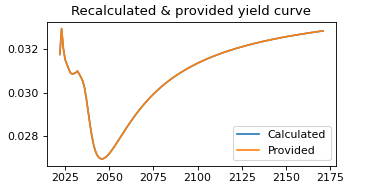

In [373]:
fig, ax1 = plt.subplots(1,1)
ax1.plot(x_data_label, r_Target.values, color='tab:blue',label="Calculated")
ax1.plot(x_data_label, target_curve.values, color='tab:orange',label="Provided")

ax1.set_ylabel("Yield")
ax1.set_title('Recalculated & provided yield curve')
ax1.set_xlabel("time")
ax1.legend()
fig.set_figwidth(6)
fig.set_figheight(3)
plt.show()

***

In [374]:
test_statistics_bdp = pd.DataFrame(abs(r_Target.values-target_curve.values)*10000, columns=["Abs diff in bps"])

***
<span style=color:black>
    <b>EIOPA curve comparison</b>
</span>
<br>
<span style=color:black>   
    Absolute difference in bps
</span>

In [375]:
test_statistics_bdp.head()

,Abs diff in bps
0,3.099100e-07
1,7.135360e-03
2,4.009214e-02
3,4.545501e-02
4,1.724362e-02


***

[Back to the top](#0)
<a id="9"></a> <br>
## Test 1; Success criteria

The successful application of the success criteria marks the completion of the test.

In [376]:
result1 = SuccessTest(test_statistics_bdp.values, test_statistics_max_diff_in_bps, test_statistics_average_diff_in_bps)

Test passed
Test passed


<IPython.core.display.Javascript object>


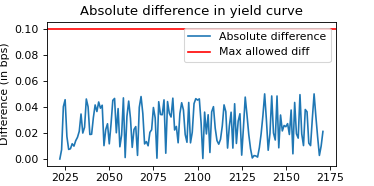

In [377]:
x_data_label = range(2022,2022+r_Target.shape[0],1)
fig, ax1 = plt.subplots(1,1)
ax1.plot(x_data_label, test_statistics_bdp, label= "Absolute difference")
ax1.axhline(y = test_statistics_max_diff_in_bps, color = 'r', linestyle = '-',label="Max allowed diff")

ax1.set_xlabel("time")
ax1.set_ylabel("Difference (in bps)")
ax1.set_title('Absolute difference in yield curve')
ax1.legend()
fig.set_figwidth(6)
fig.set_figheight(3)

plt.show()

[Back to the top](#0)
<a id="10"></a> <br>
## Conclusion

The EIOPA curve generated for December 2022 has passed the success criteria. Based on the preformed tests, it is likely that the curve was generated using the Smith & Wilson algorithm with the calibration vector that was provided in the file *EIOPA_RFR_20221231_Qb_SW.xlsx* and the parameters displayed in the file *EIOPA_RFR_20221231_Term_Structures.xlsx*.

In [378]:
pd.DataFrame(data = [result1], columns = ["Mean test","Max test"],  \
             index= ["Provided vs calculated"])

,Mean test,Max test
Provided vs calculated,True,True
